<a href="https://colab.research.google.com/github/samuel23taku/NoteBooks/blob/main/DiffusionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading

torch.Size([3000, 1, 28, 28])


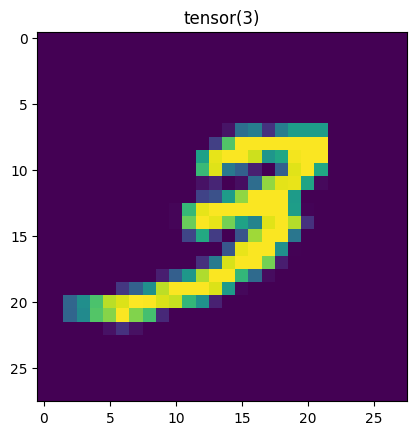

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torchvision.transforms import  ToTensor, Normalize
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

# Other code
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

testing_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

train_dataloader = DataLoader(
    training_data, batch_size = 3000,shuffle=True
)
test_dataloader = DataLoader(
    testing_data, batch_size = 3000,shuffle=True
)


train_features,train_labels = next(iter(train_dataloader))
print(train_features.shape)
eg_image = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(eg_image)
plt.title(label)
plt.show()

# Diffusion Process



In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Util_DoubleConv(nn.Module):
  def __init__(self,in_channels,out_channels,mid_channels=None): # mid_channels for number of neurons in the middle layer
    super().__init__()
    if not mid_channels:
        mid_channels = out_channels
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self,x):
    return self.double_conv(x)

class Util_DownScale(nn.Module):
  def __init__(self,in_channels,out_channels):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
        nn.MaxPool2d(kernel_size=2),
        Util_DoubleConv(in_channels,out_channels)
    )

  def forward(self,x):
    return self.maxpool_conv(x)

class Util_UpScale(nn.Module):
  def __init__(self,in_channels,out_channels,bilinear=True): # Either use bilinear or transposed Conv2d
    super().__init__()
    if bilinear:
      self.up = nn.Upsample(scale_factor=2,mode="bilinear",align_corners=True)
      self.conv = Util_DoubleConv(in_channels=in_channels,out_channels=out_channels,mid_channels= in_channels // 2)
    else:
      self.up = nn.ConvTranspose2d(in_channels=in_channels,out_channels=out_channels,kernel_size = 2,stride=2)
      self.conv = Util_DoubleConv(in_channels,out_channels,mid_channels= in_channels // 2)

  def forward(self,x1,x2):
    '''
        x2 is a skip connection value from the encoder,
        while x1 is the decoder current state
    '''

    x1 = self.up(x1)

    # Compute height difference between x1 and x2
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]

    # Make x1 match the size of x2
    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,diffY // 2, diffY - diffY // 2])

    # Do skip connection by concaticating tensor from different layers
    x = torch.cat([x2,x1],dim=1)

    return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class DiffusionUNet(nn.Module):
    def __init__(self, in_channels, n_classes, bilinear=False):
        super(DiffusionUNet, self).__init__()
        self.n_channels = in_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.n_times = 1000
        self.img_H, self.img_W, self.img_C = [28,28,1]

        self.inc = (Util_DoubleConv(in_channels, 64))
        self.down1 = (Util_DownScale(64, 128))
        self.down2 = (Util_DownScale(128, 256))
        self.down3 = (Util_DownScale(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Util_DownScale(512, 1024 // factor))
        self.up1 = (Util_UpScale(1024, 512 // factor, bilinear))
        self.up2 = (Util_UpScale(512, 256 // factor, bilinear))
        self.up3 = (Util_UpScale(256, 128 // factor, bilinear))
        self.up4 = (Util_UpScale(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
      x1 = self.inc(x)
      x2 = self.down1(x1)
      x3 = self.down2(x2)
      x4 = self.down3(x3)
      x5 = self.down4(x4)
      x = self.up1(x5, x4)
      x = self.up2(x, x3)
      x = self.up3(x, x2)
      x = self.up4(x, x1)
      logits = self.outc(x)
      return logits



# The noising part
def forward_diffusion(alphas_cumprod, x_start, t, noise):
    batch_size, _, height, width = x_start.size()
    # Expand alphas_cumprod[t] to match the shape of x_start and noise
    alphas_cumprod_t = alphas_cumprod[t].view(batch_size, 1, 1, 1).expand(batch_size, 1, height, width).to(x_start.device)
    return torch.sqrt(alphas_cumprod_t) * x_start + torch.sqrt(1 - alphas_cumprod_t) * noise


## Training Loop

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
T = 1000

def get_alphas_cumprod(T):
    betas = np.linspace(1e-4, 0.02, T)
    alphas = 1 - betas
    alphas_cumprod = np.cumprod(alphas)
    return alphas_cumprod

def train_model(train_loader,epoch_counts=3,lr=1e-3,weights_save_path = "./weights"):
  alphas_cumprod = get_alphas_cumprod(T)
  alphas_cumprod = torch.tensor(alphas_cumprod).float().to(device)

  model = DiffusionUNet(in_channels=1,n_classes=1,bilinear=False)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=lr)
  loss_criterion = nn.MSELoss()
# Generate alpha values to noise on each timestep
  model.train()
  for epoch in range(epoch_counts):
    epoch_start_time = time.time()  # Start time before epoch begins
    epoch_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
      data = data.view(-1,1,28,28).to(device) # Reshape and
      t = torch.randint(0,T,(data.size(0),),dtype=torch.long,device=device)
      noise = torch.randn_like(data,device=device)
      x_t = forward_diffusion(alphas_cumprod,data,t,noise)

      optimizer.zero_grad()
      predicted_noise = model(x_t)
      loss = loss_criterion(predicted_noise, noise)
      loss.backward()
      # Update model weights
      optimizer.step()

      epoch_loss += loss.item()

    epoch_end_time = time.time()
    formatted_time = str(datetime.timedelta(seconds=int(epoch_end_time - epoch_start_time)))

    print(f'Epoch {epoch+1} || Time taken {formatted_time} ||  Loss: {epoch_loss :.4f}')
    torch.save(model.state_dict(),f"weights_{epoch}.pth")

  # Save weights

train_model(train_loader = train_dataloader, epoch_counts = 50)

Using device: cuda
Epoch 1 || Time taken 0:00:16 ||  Loss: 5.0090
Epoch 2 || Time taken 0:00:16 ||  Loss: 1.8238
Epoch 3 || Time taken 0:00:16 ||  Loss: 1.3766
Epoch 4 || Time taken 0:00:16 ||  Loss: 1.2278
Epoch 5 || Time taken 0:00:16 ||  Loss: 1.1152
Epoch 6 || Time taken 0:00:16 ||  Loss: 1.0357
Epoch 7 || Time taken 0:00:16 ||  Loss: 1.0149
Epoch 8 || Time taken 0:00:16 ||  Loss: 0.9458
Epoch 9 || Time taken 0:00:16 ||  Loss: 0.9208
Epoch 10 || Time taken 0:00:16 ||  Loss: 0.9127
Epoch 11 || Time taken 0:00:16 ||  Loss: 0.8821
Epoch 12 || Time taken 0:00:16 ||  Loss: 0.8650
Epoch 13 || Time taken 0:00:16 ||  Loss: 0.8448
Epoch 14 || Time taken 0:00:16 ||  Loss: 0.8272
Epoch 15 || Time taken 0:00:16 ||  Loss: 0.8282
Epoch 16 || Time taken 0:00:16 ||  Loss: 0.8065
Epoch 17 || Time taken 0:00:16 ||  Loss: 0.7818
Epoch 18 || Time taken 0:00:16 ||  Loss: 0.7783
Epoch 19 || Time taken 0:00:16 ||  Loss: 0.7878
Epoch 20 || Time taken 0:00:16 ||  Loss: 0.7658
Epoch 21 || Time taken 0:00:16

Model weights loaded from weights_48.pth
torch.Size([5, 1, 28, 28])


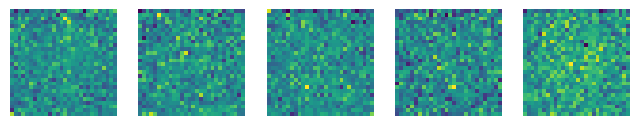

In [11]:
# Loading Model Weights
T = 1000
def load_model(model,weights_path):
    model.load_state_dict(torch.load(weights_path))
    model.eval()
    print(f'Model weights loaded from {weights_path}')

# Load the model weights
model = DiffusionUNet(in_channels=1,n_classes=1,bilinear=False).to(device)
load_model(model,"weights_48.pth")

alphas_cumprod = get_alphas_cumprod(T)
alphas_cumprod = torch.tensor(alphas_cumprod).float()

epsilon = 1e-8  # Small constant to avoid division by zero
def sample():
  with torch.no_grad():
    x = torch.randn(5, 1, 28, 28, device=device)  # Start with random noise
    for t in reversed(range(T)):
      predicted_noise = model(x)
      # print("Predicted noise is ",x) Returning NaN
      sqrt_alpha = np.sqrt(alphas_cumprod[t] + epsilon)  # Add epsilon here

      image = (x - predicted_noise) / sqrt_alpha
  return image.cpu()

images = sample()
print(images.shape)

plt.figure(figsize=(8, 8))
for i in range(len(images)):  # Use len(generated_images) to match the number of images generated
    plt.subplot(1, len(images), i+1)
    plt.imshow(images[i].reshape(28, 28))
    plt.axis('off')
plt.show()

# Can you see the numbers